### One example showing the broadband and multiband prediction workflows
Written by Congcong Yuan, 2023-02

#### import packages

In [1]:
from os import listdir
from os.path import isfile, join
from operator import attrgetter
from time import time
import numpy as np
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.io.sac.core import _read_sac
from obspy.clients.fdsn.header import FDSNException
import matplotlib.pyplot as plt
import pandas as pd
import sys
import copy
import obspy
from obspy.core.stream import Stream
from obspy import UTCDateTime
from obspy import read
import time

from logging import raiseExceptions
import seisbench.models as sbm
import torch

# sys.path.insert(0,os.path.abspath('/Users/jackie_yuan/Documents/software/QuakeAI/Collections/Others/REAL/myCodes'))
sys.path.append('../../ELEP/src/')
from mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from mbf import MB_filter as MBF

#### load data and models

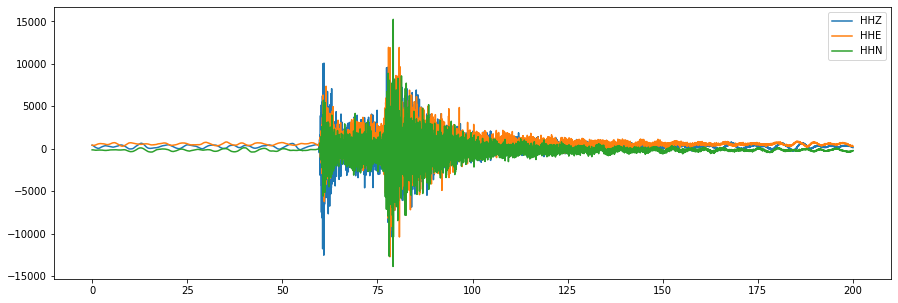

In [2]:
# download example waveforms
starttime = UTCDateTime("2007/01/02 05:48:50")
net, sta, loc, chan = "CX", "PB01", "*", "HH?"
client = Client("GFZ")

stream = client.get_waveforms(network=net, station=sta, location=loc, channel=chan, starttime=starttime-50, endtime=starttime+150)

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()
plt.show()

In [3]:
# load detectors and pickers
pn_model = sbm.PhaseNet.from_pretrained("scedc")
gpd_model = sbm.GPD.from_pretrained("scedc")
eqt_model = sbm.EQTransformer.from_pretrained("scedc")

#### broadband prediction

In [4]:
# perform prediction
# note: exactly same as the examples on the SeisBench
time0 = time.time()
pn_annotations = pn_model.annotate(stream)
gpd_annotations = gpd_model.annotate(stream)
eqt_annotations = eqt_model.annotate(stream)
time1 = time.time()
print(f'Broadband costs = {time1-time0} s on the prediction.')

Broadband costs = 2.4960551261901855 s on the prediction.


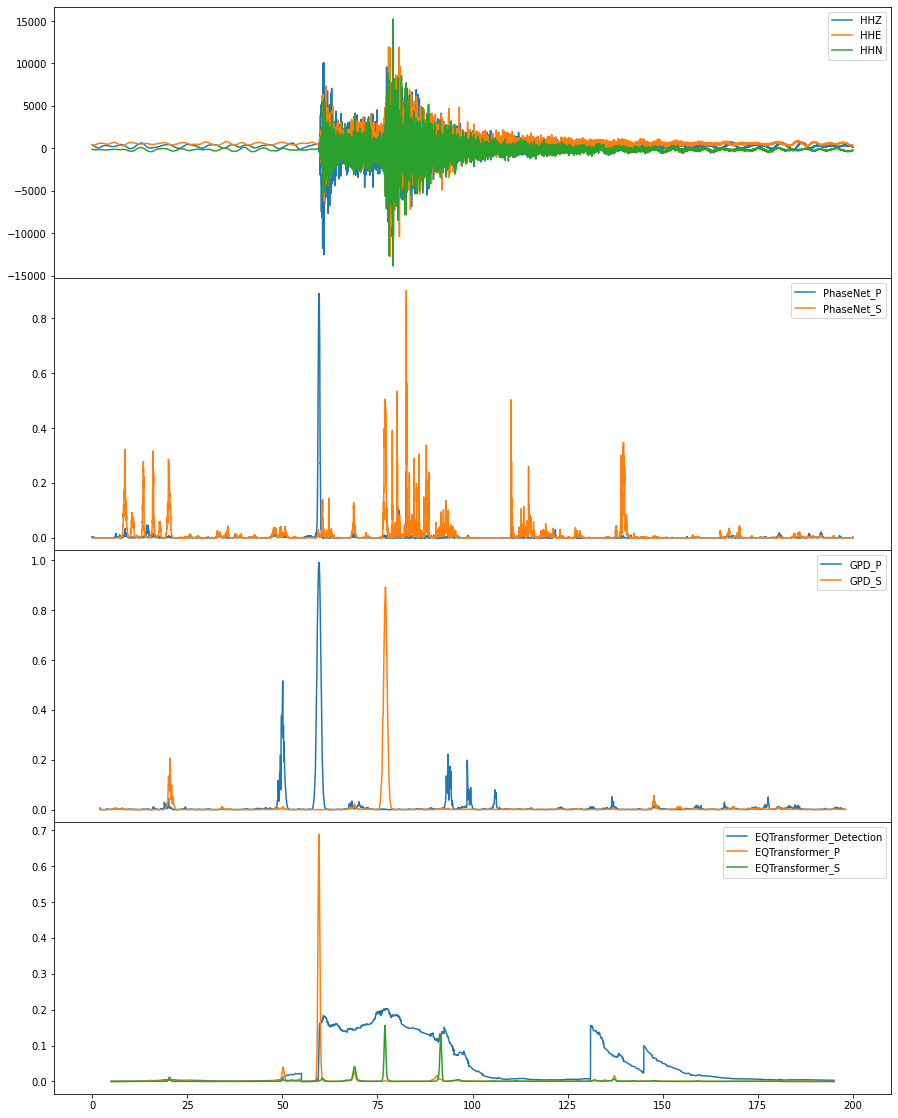

In [5]:
# visialization predicted results
fig = plt.figure(figsize=(15, 20))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0})

offset_pn = pn_annotations[0].stats.starttime - stream[0].stats.starttime
offset_gpd = gpd_annotations[0].stats.starttime - stream[0].stats.starttime
offset_eqt = eqt_annotations[0].stats.starttime - stream[0].stats.starttime
for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
    if pn_annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[1].plot(pn_annotations[i].times() + offset_pn, pn_annotations[i].data, label=pn_annotations[i].stats.channel)
    if gpd_annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[2].plot(gpd_annotations[i].times() + offset_gpd, gpd_annotations[i].data, label=gpd_annotations[i].stats.channel)
    if eqt_annotations[i].stats.channel[-1] != "N":  # Do not plot noise curve
        axs[3].plot(eqt_annotations[i].times() + offset_eqt, eqt_annotations[i].data, label=eqt_annotations[i].stats.channel)

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

#### multiband prediction

In [6]:
# config parameters
fqmin, fqmax = 1, 20 # min and max for bandpass filter
dt, fs = 0.01, 100 # standard sampling rate
nt, nc = 20001, 3   # standard 6000

nfqs, fq_flag = 20, 'log' # number of narrow frequency bands and type of frequency discretization 
npoles = 2 # number of single-pole filtering
if fq_flag == 'log':
    fq_list = make_LogFq(fqmin, fqmax, dt, nfqs) # make log-spaced frequencies
elif fq_flag == 'line':
    fq_list = make_LinFq(fqmin, fqmax, dt, nfqs) # make linear-spaced frequencies
    
coeff_HP, coeff_LP = rec_filter_coeff(fq_list, dt) # produce high-pass and low-pass filtering coefficients

# assemble above parameters into a dict 
MBF_paras = {'f_min':fqmin, 'f_max':fqmax, 'nfqs':nfqs, 'frequencies':fq_list, 'CN_HP':coeff_HP, 'CN_LP':coeff_LP, \
    'dt':dt, 'fs':fs, 'nt':nt, 'nc':nc}

In [7]:
# setup parameters for signal decomposition
MBF_filter_paras = {'f_min':1, 'f_max':45, 'nfbs':20, 'frequencies':[], 'dt':0.01, 'CN_HP':[], 'CN_LP':[], 'npoles':2} 
MBF_filter_paras['frequencies'] = make_LogFq(MBF_filter_paras['f_min'], MBF_filter_paras['f_max'], MBF_filter_paras['dt'], MBF_filter_paras['nfbs'])
MBF_filter_paras['CN_HP'], MBF_filter_paras['CN_LP'] = rec_filter_coeff(MBF_filter_paras['frequencies'], MBF_filter_paras['dt'])
freq_list = MBF_filter_paras['frequencies']
MBF_filter_paras['detection_threshold'], MBF_filter_paras['P_threshold'], MBF_filter_paras['S_threshold'] = 0.3, 0.1, 0.1
MBF_filter_paras['estimate_uncertainty'] = None
nfbs = len(freq_list-1)
MBF_filter_paras['nfbs'] = nfbs
stt = UTCDateTime(stream[0].stats['starttime'])
edt = UTCDateTime(stream[0].stats['endtime'])
MBF_filter_paras['starttime'] = stt
MBF_filter_paras['endtime'] = edt
components = []
for ic in range(nc):
    components.append(stream[ic].stats['channel'][-1])
MBF_filter_paras['components'] = components

In [8]:
# generate a stream for seisbench prediction
# multi-band filtering
mbf_clear_data = np.zeros([nfbs, nt, nc])
for ic in range(nc):
    mbf_clear_data[:, :, ic] = MBF(stream[ic].data, MBF_filter_paras)
# assemble for prediction   
mbf_stream = obspy.Stream()
for ifb in range(nfbs-1):
    mbf_clear_dict = {'network': net, 'station': sta, 'location': None, 'channel': chan[:-1], 'components': components, 'starttime': stt, \
        'endtime': edt, 'sampling_rate': fs, 'delta': dt, 'npts': nt, 'azimuth': None, 'back_azimuth': None, \
            'n_channels': nc, 'frequency_band_index': ifb, 'frequency_band':[freq_list[ifb], freq_list[ifb+1]], 'data': np.squeeze(mbf_clear_data[ifb, :, :])}

    mbf_trace = create_obspy_trace(mbf_clear_dict)
    for ic in range(nc):
        mbf_stream += mbf_trace[ic]

In [9]:
# perform prediction on multi-band data
time0 = time.time()
pn_mbf_annotations = pn_model.annotate(mbf_stream)
gpd_mbf_annotations = gpd_model.annotate(mbf_stream)
eqt_mbf_annotations = eqt_model.annotate(mbf_stream)
time1 = time.time()
print(f'Multiband costs = {time1-time0} s on the prediction.')

Multiband costs = 44.1449031829834 s on the prediction.


57 Trace(s) in Stream:

CX.PB01.fb00.PhaseNet_P | 2007-01-02T05:47:59.998392Z - 2007-01-02T05:51:19.998392Z | 100.0 Hz, 20001 samples
...
(55 other traces)
...
CX.PB01.fb18.PhaseNet_N | 2007-01-02T05:47:59.998392Z - 2007-01-02T05:51:19.998392Z | 100.0 Hz, 20001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces] 0.0


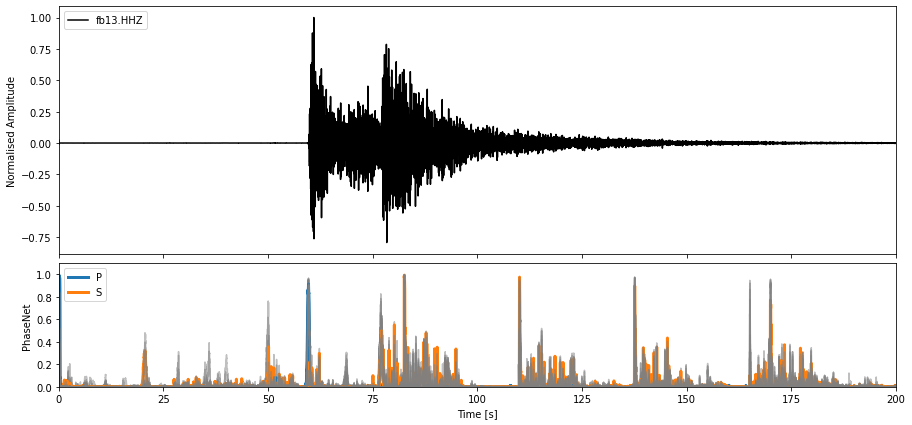

57 Trace(s) in Stream:

CX.PB01.fb00.GPD_P | 2007-01-02T05:48:01.998392Z - 2007-01-02T05:51:17.998392Z | 10.0 Hz, 1961 samples
...
(55 other traces)
...
CX.PB01.fb18.GPD_N | 2007-01-02T05:48:01.998392Z - 2007-01-02T05:51:17.998392Z | 10.0 Hz, 1961 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces] 2.0


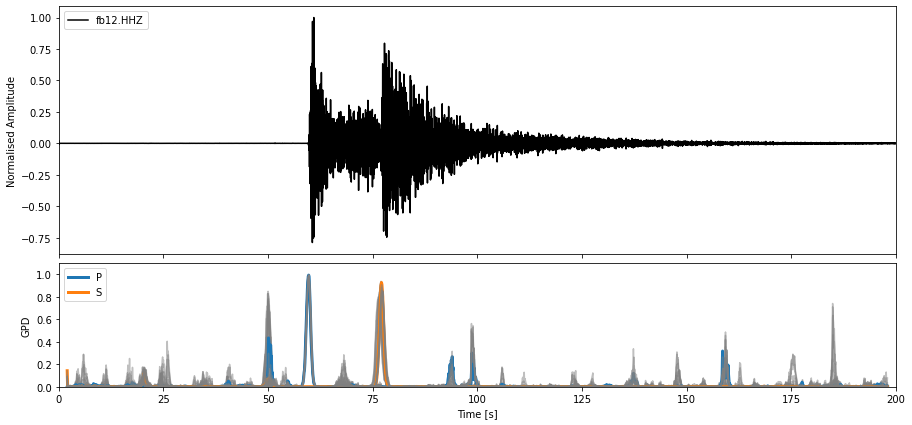

57 Trace(s) in Stream:

CX.PB01.fb00.EQTransformer_Detection | 2007-01-02T05:48:04.998392Z - 2007-01-02T05:51:14.998392Z | 100.0 Hz, 19001 samples
...
(55 other traces)
...
CX.PB01.fb18.EQTransformer_S | 2007-01-02T05:48:04.998392Z - 2007-01-02T05:51:14.998392Z | 100.0 Hz, 19001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces] 5.0


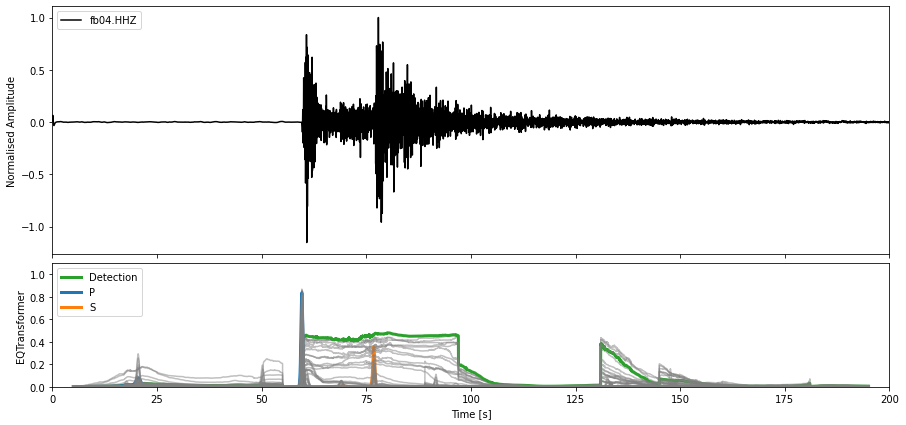

In [10]:
# visualize the prediction
wlength = 200 #@param
color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}
stream = copy.deepcopy(mbf_stream)
# eqt_preds = copy.deepcopy(eqt_mbf_annotations)
for mdl_annotate in [pn_mbf_annotations, gpd_mbf_annotations, eqt_mbf_annotations]:
    eqt_preds = copy.deepcopy(mdl_annotate)

    # find the optimal pick among multiple frequency bands
    pred_npts = eqt_preds[0].stats.npts
    pred_starttime =  eqt_preds[0].stats.starttime
    pred_delta = eqt_preds[0].stats.delta
    npreds = int(len(eqt_preds)/3)

    prob_detect_data = np.zeros([npreds, pred_npts])
    prob_p_pick_data = np.zeros([npreds, pred_npts])
    prob_s_pick_data = np.zeros([npreds, pred_npts])

    for ipred in range(npreds):
        prob_detect_data[ipred,:] = eqt_preds[ipred*3].data
        prob_p_pick_data[ipred,:] = eqt_preds[ipred*3+1].data
        prob_s_pick_data[ipred,:] = eqt_preds[ipred*3+2].data

    detect_prob_max_index = np.argwhere(prob_detect_data==np.amax(prob_detect_data))
    p_prob_max_index = np.argwhere(prob_p_pick_data==np.amax(prob_p_pick_data))
    s_prob_max_index = np.argwhere(prob_s_pick_data==np.amax(prob_s_pick_data))
    ipick_optimal = detect_prob_max_index[0,0]
    # print(f'detect_prob_max_index: {detect_prob_max_index}')
    # print(f'p_prob_max_index: {p_prob_max_index}')
    # print(f's_prob_max_index: {s_prob_max_index}')

    for s in range(0, int(stream[0].stats.endtime - stream[0].stats.starttime), wlength):
        t0 = stream[0].stats.starttime + s
        t1 = t0 + wlength
        subst = stream.slice(t0, t1)

        fig, ax = plt.subplots(2, 1, figsize=(15, 7), sharex=True, gridspec_kw={'hspace' : 0.05, 'height_ratios': [2, 1]})
        
        for i, preds in enumerate([eqt_preds]):
            subpreds = preds.slice(t0, t1)
            offset = subpreds[0].stats.starttime - subst[0].stats.starttime
            print(subpreds, offset)
            for j, pred_trace in enumerate(subpreds):
                model, pred_class = pred_trace.stats.channel.split("_")
                if pred_class == "N":
                    # Skip noise traces
                    continue
                c = color_dict[pred_class]
                if (j < (ipick_optimal+1)*3) and (j >= ipick_optimal*3):
                    ax[i+1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c,  linewidth=3)
                    ax[i+1].set_ylabel(model)
                    ax[i+1].legend(loc=2)
                    ax[i+1].set_ylim(0, 1.1)
                else:
                    ax[i+1].plot(offset + pred_trace.times(), pred_trace.data, label=None, c='gray', alpha=0.5)
            
            ax[0].plot(subst[ipick_optimal*3].times(), subst[ipick_optimal*3].data/np.amax(subst[ipick_optimal*3].data), 'k', label=subst[ipick_optimal*3].stats.location+'.'+subst[ipick_optimal*3].stats.channel)
            ax[0].set_xlim(0, wlength)
            ax[0].set_ylabel('Normalised Amplitude')
            ax[1].set_xlabel('Time [s]')
            ax[0].legend(loc=2)
        plt.show()